In [1]:
pip install torch torchvision matplotlib


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farzadnekouei/50k-celebrity-faces-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 333M/333M [00:04<00:00, 86.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/farzadnekouei/50k-celebrity-faces-image-dataset/versions/1


In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [4]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [5]:
dataset = datasets.ImageFolder(
    root=path,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)

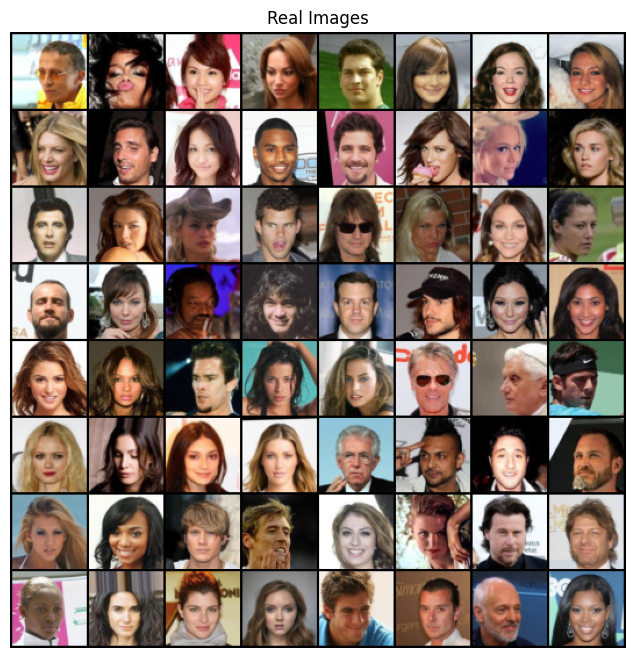

In [6]:
real_batch = next(iter(dataloader))
images = real_batch[0]

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(torchvision.utils.make_grid(images[:64], padding=2, normalize=True).permute(1,2,0))


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = 100
ngf = 64
nc = 3


ـGenerator

In [8]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: noise (batch, 100, 1, 1)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


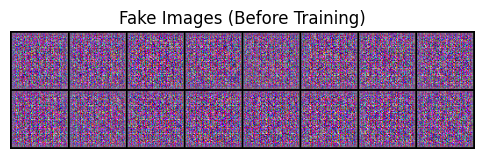

In [9]:
netG = Generator().to(device)

noise = torch.randn(16, nz, 1, 1, device=device)
fake_images = netG(noise)

plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Fake Images (Before Training)")
plt.imshow(torchvision.utils.make_grid(fake_images, normalize=True).cpu().permute(1,2,0))

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (nc) x 64 x 64
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [11]:
netD = Discriminator().to(device)

output = netD(fake_images.detach())
print(output.shape)


torch.Size([16, 1, 1, 1])


In [12]:
criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [13]:
real_label = 1.
fake_label = 0.


In [14]:
num_epochs = 150


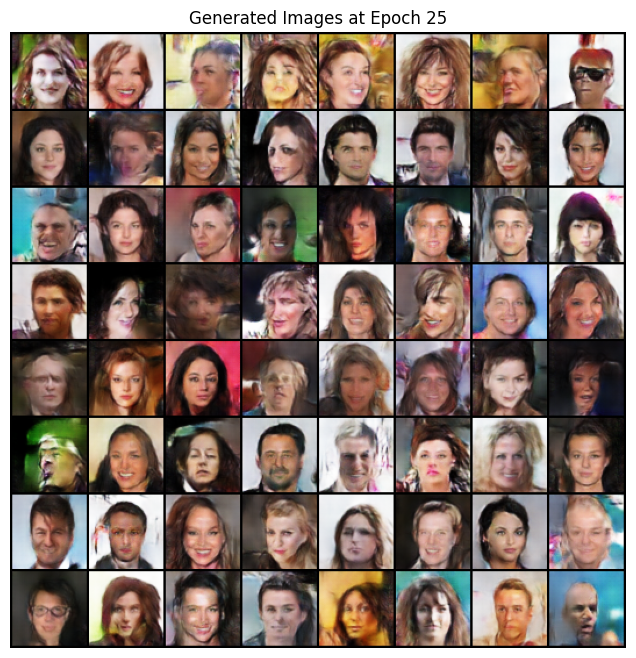

Epoch 26/150:  28%|██▊       | 110/391 [00:18<00:43,  6.40it/s]

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

# Assuming you already have:
# netG, netD, dataloader, criterion, optimizerG, optimizerD, device, nz, num_epochs
# real_label = 1, fake_label = 0

best_g_loss = float('inf')

for epoch in range(num_epochs):
    # Loop over batches
    for i, data in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        ############################
        # (1) Train Discriminator
        ############################
        netD.zero_grad()

        # Train with real images
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        # Update Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Train Generator
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # Generator tries to fool discriminator
        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # Print losses at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")

    # Save checkpoint (for resuming)
    torch.save({
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'errG': errG.item(),
        'errD': errD.item(),
    }, 'gan_checkpoint.pth')

    # Save BEST Generator
    if errG.item() < best_g_loss:
        best_g_loss = errG.item()
        torch.save(netG.state_dict(), 'best_generator.pth')
        print(f"🌟 Best Generator saved (G_loss = {best_g_loss:.4f})")

    # Generate and display images after each epoch
    with torch.no_grad():
        noise = torch.randn(64, nz, 1, 1, device=device)
        fake_images = netG(noise).cpu()

    # Clear previous output (optional, for cleaner display in Jupyter)
    clear_output(wait=True)

    # Display images
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch+1}")
    plt.imshow(torchvision.utils.make_grid(fake_images, normalize=True).permute(1, 2, 0))
    plt.savefig(f'generated_epoch_{epoch+1}.png')  # Save image to file
    plt.show()
    plt.close()

print("Training completed!")